# Compresión de imágenes RGB

In [20]:
import pkg_resources
import subprocess

def check_package(package_name):
    try:
        pkg_resources.get_distribution(package_name)
    except pkg_resources.DistributionNotFound:
        print(f"{package_name} is not installed. Installing...")
        subprocess.check_call(["pip", "install", package_name])
        print(f"{package_name} has been installed correctly.")

check_package('scikit-image')

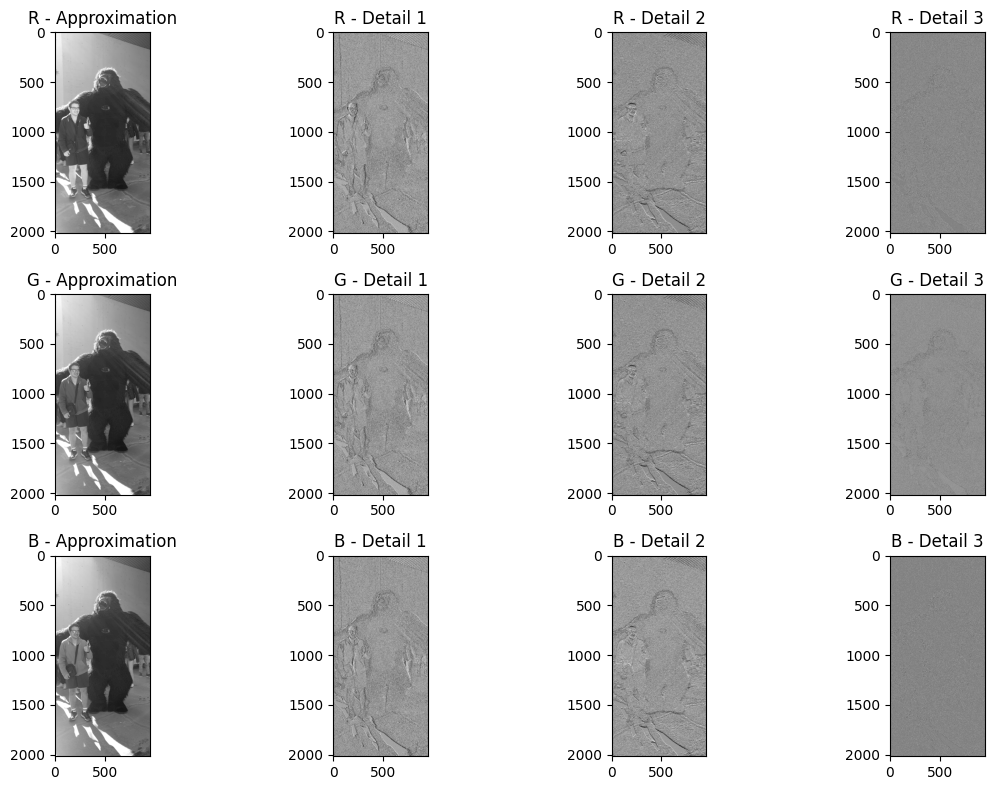

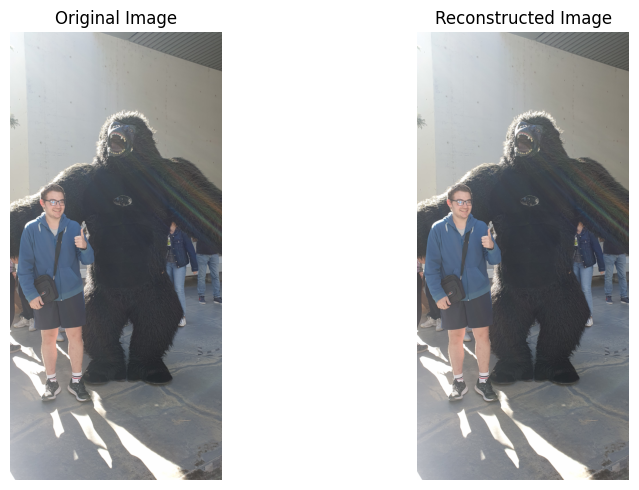

True

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from PIL import Image
check_package('scikit-image')
check_package('scipy')
check_package('opencv-python')
from skimage import exposure
from scipy import ndimage
import cv2

# Load an RGB image
image_path = './data/harambe.jpg'  # Replace with your image path
img = Image.open(image_path)
img_array = np.array(img)

# Split the image into RGB channels
r, g, b = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]

# Perform wavelet transform on each channel separately
def apply_wavelet(channel):
    coeffs = pywt.dwt2(channel, 'haar')  # Using Haar wavelet, you can change this
    cA, (cH, cV, cD) = coeffs  # Approximation, Horizontal, Vertical, Diagonal details
    return cA, cH, cV, cD

# Apply wavelet transform to each channel

r_coeffs = apply_wavelet(r)
g_coeffs = apply_wavelet(g)
b_coeffs = apply_wavelet(b)

# Displaying the results for R, G, and B channels after wavelet transform using axs
fig, axs = plt.subplots(3, 4, figsize = (12, 8))

# Plotting RGB channels after wavelet transform (including rotation and flipping)
for i, coeffs in enumerate([r_coeffs, g_coeffs, b_coeffs]):
    # Display the approximation coefficients
    axs[i, 0].imshow(np.fliplr(np.transpose(coeffs[0])), cmap='gray')  # Flip vertically after transpose
    axs[i, 0].set_title(f'{["R", "G", "B"][i]} - Approximation')

    # Display the detail coefficients with enhanced contrast
    for j, coeff in enumerate(coeffs[1:]):
        equalized_coeff = exposure.equalize_hist(coeff)
        equalized_coeff_rotated = np.fliplr(np.transpose(equalized_coeff))  # Flip vertically after transpose
        
        axs[i, j+1].imshow(equalized_coeff_rotated, cmap='gray')
        axs[i, j+1].set_title(f'{["R", "G", "B"][i]} - Detail {j+1}')

plt.tight_layout()
plt.show()

# Function to reconstruct channel from wavelet coefficients
def reconstruct_channel(cA, cH, cV, cD, wavelet_type):
    coeffs = (cA, (cH, cV, cD))
    reconstructed_channel = pywt.idwt2(coeffs, wavelet_type)  # Inverse wavelet transform
    return reconstructed_channel

# Reconstruct each channel using the inverse wavelet transform
reconstructed_r = reconstruct_channel(*r_coeffs, 'haar')
reconstructed_g = reconstruct_channel(*g_coeffs, 'haar')
reconstructed_b = reconstruct_channel(*b_coeffs, 'haar')

# Combine the reconstructed channels into an RGB image
reconstructed_image = np.stack((reconstructed_r, reconstructed_g, reconstructed_b), axis=-1)

# Clip the reconstructed image data to the valid range
reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8) / 255.0
reconstructed_image = np.fliplr(np.transpose(reconstructed_image, (1, 0, 2)))

img = np.fliplr(np.transpose(img, (1, 0, 2)))

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Display the original image on the first subplot
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the reconstructed image on the second subplot
axes[1].imshow(reconstructed_image)
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

# Convert the image data type to uint8 and color format to BGR if needed
reconstructed_image_uint8 = np.clip(reconstructed_image * 255, 0, 255).astype(np.uint8)
bgr_image = cv2.cvtColor(reconstructed_image_uint8, cv2.COLOR_RGB2BGR)

# Save the image using cv2.imwrite()
output_image_path = './data/harambe_modified.jpg'
cv2.imwrite(output_image_path, bgr_image)

In [ ]:
def apply_wavelet_compression(coeffs, threshold):
    cA, (cH, cV, cD) = coeffs
    # Apply compression by thresholding the detail coefficients
    cH_compressed = pywt.threshold(cH, threshold)
    cV_compressed = pywt.threshold(cV, threshold)
    cD_compressed = pywt.threshold(cD, threshold)
    return cA, (cH_compressed, cV_compressed, cD_compressed)

# Set your compression threshold
compression_threshold = 0.1

# Apply compression to the coefficients
r_coeffs_compressed = apply_wavelet_compression(r_coeffs, compression_threshold)
g_coeffs_compressed = apply_wavelet_compression(g_coeffs, compression_threshold)
b_coeffs_compressed = apply_wavelet_compression(b_coeffs, compression_threshold)

# Reconstruct the image using compressed coefficients
reconstructed_r_compressed = reconstruct_channel(*r_coeffs_compressed, 'haar')
reconstructed_g_compressed = reconstruct_channel(*g_coeffs_compressed, 'haar')
reconstructed_b_compressed = reconstruct_channel(*b_coeffs_compressed, 'haar')

# Combine the compressed channels into an RGB image
reconstructed_image_compressed = np.stack((reconstructed_r_compressed, reconstructed_g_compressed, reconstructed_b_compressed), axis=-1)

# Clip the reconstructed image data to the valid range
reconstructed_image_compressed = np.clip(reconstructed_image_compressed, 0, 255).astype(np.uint8) / 255.0
